In [68]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from model import Vocaburary, TextGCN

import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
from matplotlib.figure import Figure

from IPython.display import clear_output

import os
import pickle

In [69]:
EPOCH = 300
HIDDEN_DIM = 200
SAVE_PATH = './result/eta_w_effect_gt_1.result'

In [70]:
dataset_names = {
    "20NewsGroup": "20NG",
    "MR":"mr",
    "Ohsumed":"ohsumed_single_23",
    "R52":"R52",
    "R8":"R8"
}
all_keys = [k for k in dataset_names.keys()]

In [71]:
eta_d = 1.0
eta_ws = np.arange(0., 10, 0.5)
eta_c = 1.0
w_results = {
    k:{
        'BEST_ACC': []
       }
       for k in all_keys
}

In [72]:
if not os.path.isfile(SAVE_PATH):
    for key in all_keys:
        clear_output()
        print(f'Current Dataset {key}')
        dir_name = dataset_names[key]
        dict_data = torch.load(f'./ProcessedData/{dir_name}/WholeGraphDict.gh')
        voc : Vocaburary = dict_data['voc']
        whole_graph = dict_data['whole_graph'].cuda()
        word_num = dict_data['W']
        label_num = dict_data['L']
        doc_num = dict_data['D']
        train_mask = dict_data['train_mask'].cuda()
        doc_Y : torch.Tensor = dict_data['doc_Y'].cuda()
        word_Y : torch.Tensor = dict_data['word_Y'].T.cuda()
        label_Y : torch.Tensor = dict_data['label_Y'].cuda()
        train_words = list(dict_data['train_word'])
        test_words = list(dict_data['test_word'])
        train_words.sort()
        test_words.sort()
        for eta_w in eta_ws:
            log = {"ACC": [], "LOSS": []}
            model = TextGCN(whole_graph.shape[0], HIDDEN_DIM, label_num).cuda()
            optim = torch.optim.Adam(model.parameters(), lr=1e-3)
            loss_fn = torch.nn.CrossEntropyLoss()
            trainingProcess = tqdm(range(EPOCH), desc = f"eta_w = {eta_w}")
            for epoch in trainingProcess:
                total_loss = 0.
                optim.zero_grad()
                y_hat = model(whole_graph)
                doc_Y_hat = y_hat[:doc_num]
                word_Y_hat = y_hat[doc_num:-label_num]
                label_Y_hat = y_hat[doc_num+word_num :]
                doc_loss = loss_fn(doc_Y_hat[train_mask], doc_Y[train_mask])
                word_loss = loss_fn(word_Y_hat[train_words], word_Y[train_words])
                label_loss = loss_fn(label_Y_hat, label_Y)
                loss = eta_d * doc_loss + eta_w * word_loss  + eta_c * label_loss
                loss.backward()
                optim.step()
                loss_val = loss.item()
                with torch.no_grad():
                    acc_val = ((doc_Y_hat.argmax(1)[~train_mask] == doc_Y.cuda()[~train_mask]).sum() / (~train_mask).sum()).item()
                trainingProcess.set_postfix({"LOSS": loss_val, "Accuracy":acc_val})
                log['ACC'].append(acc_val)
                log["LOSS"].append(loss_val)
            w_results[key]['BEST_ACC'].append(max(log['ACC']) * 100.)
    with open(SAVE_PATH, 'wb') as f:
        pickle.dump(w_results, f)
else:
    with open(SAVE_PATH, 'rb') as f:
        w_results = pickle.load(f)

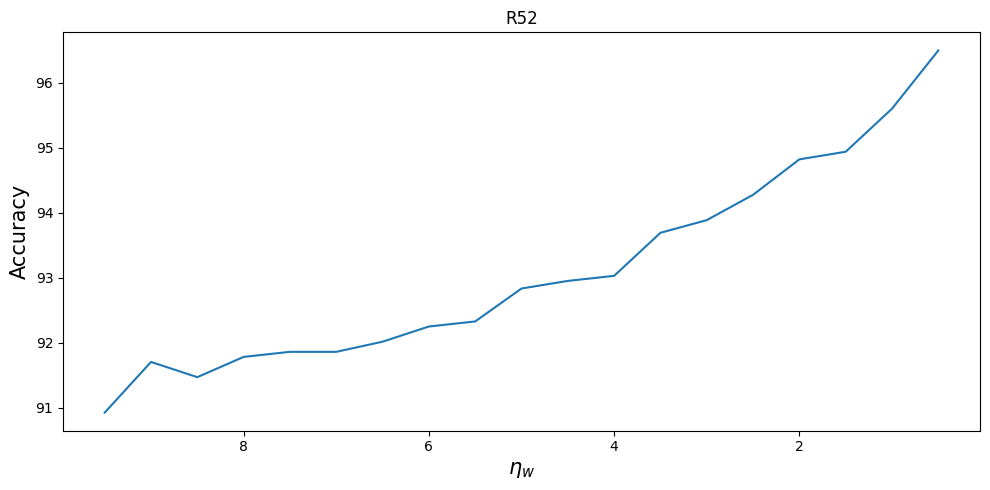

In [73]:
fig : Figure = plt.figure(figsize=(10.,5.))
plt.title("R52")
plt.plot(eta_ws[1:], w_results['R52']['BEST_ACC'][1:])
# plt.xticks(w_results['R52']['WINDOW_SIZE'])
plt.xlabel('$\\eta_{w}$', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.gca().invert_xaxis()
fig.tight_layout()
plt.show()
# fig.savefig('./result/R52_eta_w_effect_to_01.svg', transparent=True, format = 'svg')

In [74]:
all_keys.remove('R52')

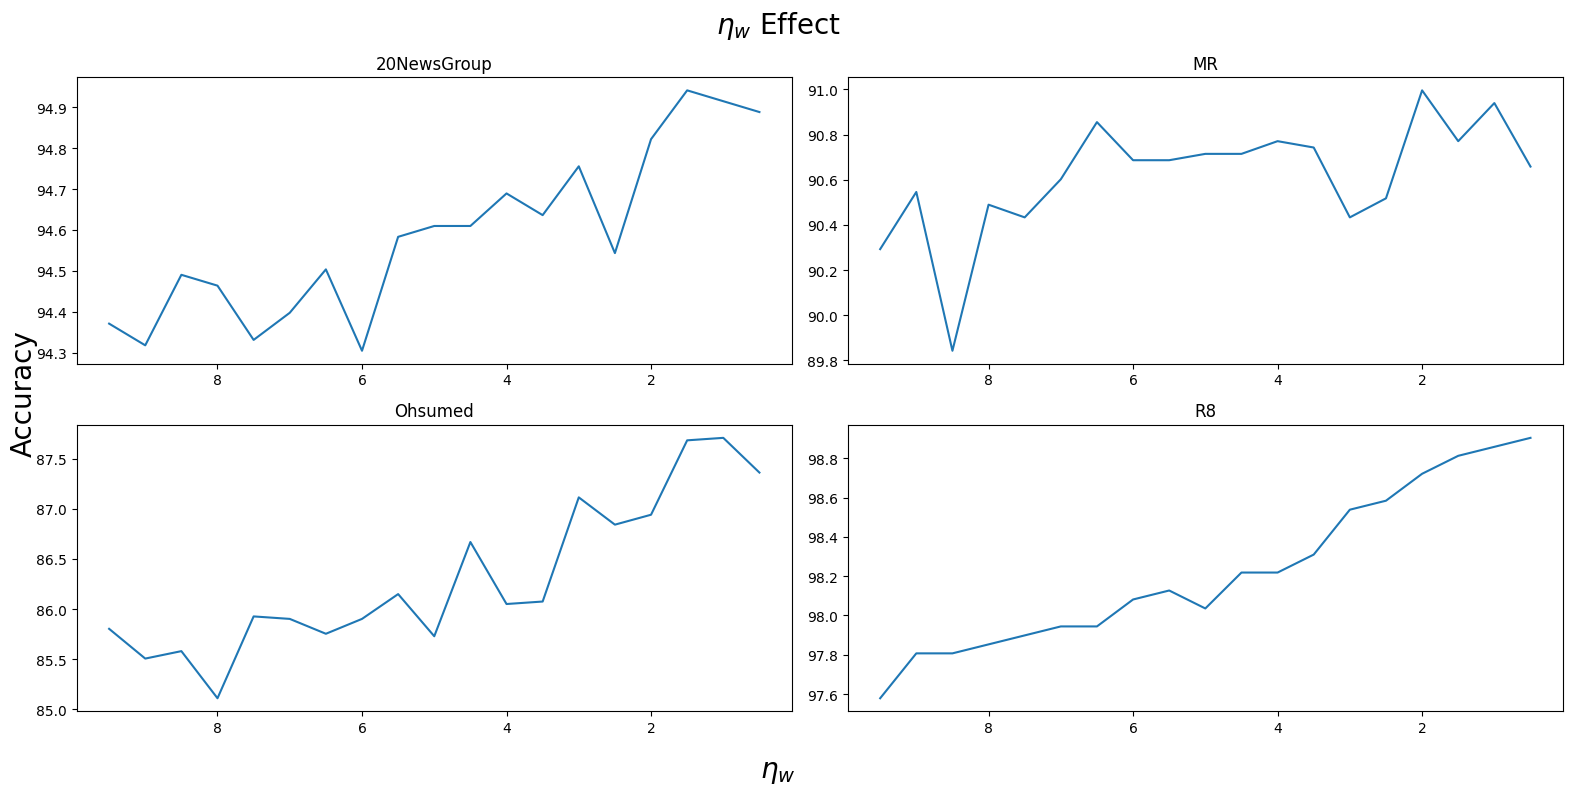

In [75]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
fig : Figure 
axs : np.ndarray[Axes]
for i, ax in enumerate(axs.flat):
    ax : Axes
    
    if i < 5:
        ax.set_title(all_keys[i])
        ax.invert_xaxis()
        ax.plot(eta_ws[1:], w_results[all_keys[i]]['BEST_ACC'][1:])
    else:
        ax.set_visible(False)
fig.set_alpha(0.0)
fig.supxlabel('$\\eta_{w}$', fontsize = 20)
fig.supylabel('Accuracy', fontsize = 20)   
fig.suptitle(t = "$\\eta_{w}$ Effect", fontsize = 20)
fig.tight_layout()
# fig.savefig('./result/Other_eta_w_effect_to_01.svg', transparent=True, format = 'svg')
plt.show()

In [76]:
all_keys.append("R52")

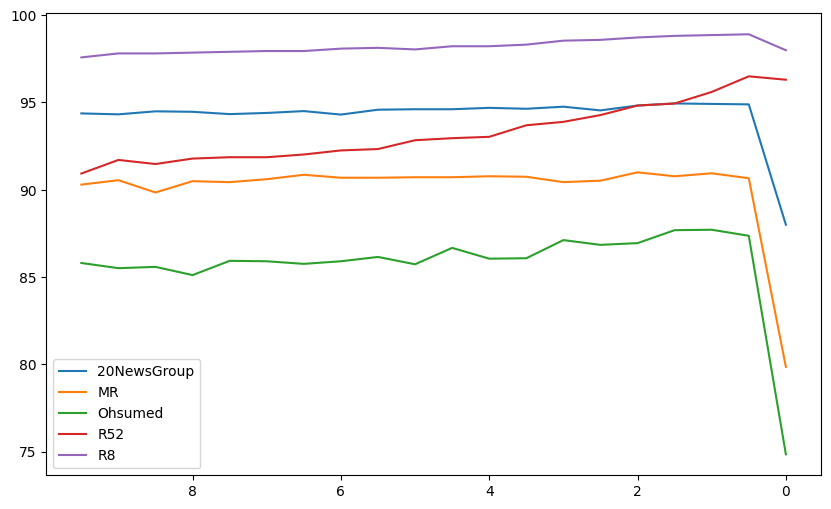

In [77]:
plt.figure(figsize=(10. , 6.))
for dataset, data in w_results.items():
    plt.plot(eta_ws, data['BEST_ACC'], label = dataset)
    plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [78]:
pd.options.display.float_format = '{:,.2f}'.format

In [79]:
processed_data = {}
processed_data['eta_w'] = eta_ws[2:]
for key, data in w_results.items():
    processed_data[key] = data['BEST_ACC'][2:]

In [80]:
df = pd.DataFrame(processed_data)

In [81]:
df = df.reindex(columns=['eta_w', 'MR', 'R8', 'R52', 'Ohsumed', '20NewsGroup'])
df = df.rename(columns={"20NewsGroup" : "20NG"})

In [82]:
df.to_csv('./result/eta_w_gt_1.csv', index=False)